## Create a model to recognise faces wearing a mask 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### **Face Detection using OpenCV**

In [4]:
imagePaths = list(paths.list_images('/content/drive/MyDrive/Colab Notebooks/Graduation_Assignment/dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


# New Section

In [5]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Compile and Train the Model

In [7]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
96/96 [==============================] - 75s 437ms/step - loss: 0.4570 - accuracy: 0.8274 - val_loss: 0.1868 - val_accuracy: 0.9754
Epoch 2/20
96/96 [==============================] - 40s 413ms/step - loss: 0.1564 - accuracy: 0.9649 - val_loss: 0.0928 - val_accuracy: 0.9831
Epoch 3/20
96/96 [==============================] - 39s 401ms/step - loss: 0.0991 - accuracy: 0.9777 - val_loss: 0.0743 - val_accuracy: 0.9792
Epoch 4/20
96/96 [==============================] - 38s 395ms/step - loss: 0.0759 - accuracy: 0.9783 - val_loss: 0.0641 - val_accuracy: 0.9792
Epoch 5/20
96/96 [==============================] - 38s 391ms/step - loss: 0.0625 - accuracy: 0.9820 - val_loss: 0.0576 - val_accuracy: 0.9805
Epoch 6/20
96/96 [==============================] - 37s 389ms/step - loss: 0.0621 - accuracy: 0.9806 - val_loss: 0.0485 - val_accuracy: 0.9831
Epoch 7/20
96/96 [==============================] - 38s 397ms/step - loss: 0.0513 - accuracy: 0.9846 - val_loss: 0.0617 - val_accuracy: 0.9767

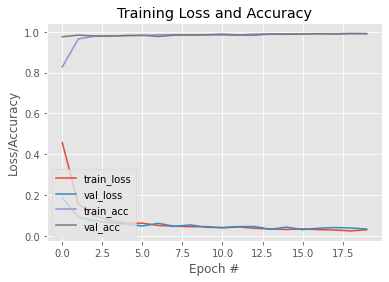

In [8]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [9]:
#To save the trained model
model.save('mask_recognition_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [1]:
# import cv2
# import os
# cascPath = os.path.dirname(
#     cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
# faceCascade = cv2.CascadeClassifier(cascPath)
# video_capture = cv2.VideoCapture(0)
# while True:
#     # Capture frame-by-frame
#     ret, frame = video_capture.read()
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = faceCascade.detectMultiScale(gray,
#                                          scaleFactor=1.1,
#                                          minNeighbors=5,
#                                          minSize=(60, 60),
#                                          flags=cv2.CASCADE_SCALE_IMAGE)
#     for (x,y,w,h) in faces:
#         cv2.rectangle(frame, (x, y), (x + w, y + h),(0,255,0), 2)
#         # Display the resulting frame
#     cv2.imshow('Video', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# video_capture.release()
# cv2.destroyAllWindows()

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
